In [2]:
from glob import glob
import logging
import pandas as pd
logging.getLogger('ppocr').setLevel(logging.ERROR)
from myutils.plate2text import process_images
from myutils.model_loader import load_model
import matplotlib.pyplot as plt
from myutils.character_level import _character_accuracy
from myutils.OCR2excel import save_ocr_results
from myutils.plate_level import _plate_level_accuracy
from myutils.average_Levenshtein import average_edit_distance
from myutils.confusion import get_character_confusion
import time
import torch

/home/awr1u24/anaconda3/envs/cw/lib/python3.11/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


[2025/05/06 03:18:32] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/awr1u24/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/awr1u24/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_n

In [3]:
# Directory containing the dataset 'license-plate-dataset'
dataset_dir = glob('data/images/test/*')

# Directory containing best models:
yolov8_path = '/home/awr1u24/ocr/models/yolov8.pt'
retina_path = '/home/awr1u24/ocr/models/retinanet.pth'
yolov5 = '/home/awr1u24/ocr/models/yolov5.pt'
faster_rcnn_path = '/home/awr1u24/ocr/models/fasterrcnn_final.pth'

# Loading the model with function load_model 
# This function can load  yolov5, yolov8, faster_rcnn, and
# Look the function in utils/model_loader.py
yolov8 = load_model('yolov8',yolov8_path)
yolov5 = load_model('yolov5', yolov5)
RetinaNet = load_model('retinanet', weight_path=retina_path, num_classes=1)
FasterRCNN = load_model('fastrcnn', weight_path=faster_rcnn_path, num_classes=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RetinaNet = RetinaNet.to(device)
FasterRCNN = FasterRCNN.to(device)
yolov5 = yolov5.to(device)

Using cache found in /home/awr1u24/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-4-30 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)

Fusing layers... 
YOLOv5s-license_plate summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


# RetinaNet

In [4]:
start_time = time.time()
retina_name, retina_accuracy, filenames = process_images(
    model=RetinaNet,
    model_name='retinanet',
    image_paths=dataset_dir,
    device='cuda:0'
)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

[2025/05/06 03:18:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1566603183746338
[2025/05/06 03:18:57] ppocr DEBUG: cls num  : 1, elapsed : 0.09158444404602051
[2025/05/06 03:18:58] ppocr DEBUG: rec_res num  : 1, elapsed : 0.3005340099334717
[2025/05/06 03:18:58] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08860993385314941
[2025/05/06 03:18:58] ppocr DEBUG: cls num  : 1, elapsed : 0.023076772689819336
[2025/05/06 03:18:58] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09467244148254395
[2025/05/06 03:18:59] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.18208074569702148
[2025/05/06 03:18:59] ppocr DEBUG: cls num  : 1, elapsed : 0.014647483825683594
[2025/05/06 03:18:59] ppocr DEBUG: rec_res num  : 1, elapsed : 0.3842437267303467
[2025/05/06 03:18:59] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.05762076377868652
[2025/05/06 03:18:59] ppocr DEBUG: cls num  : 1, elapsed : 0.010556221008300781
[2025/05/06 03:19:00] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10536456108093262
[2025/05/06 03:19:00

# Yolov5

In [5]:
start_time = time.time()
yolov5_name, yolov5_accuracy, filenames = process_images(
    model=yolov5,
    model_name='yolov5',
    image_paths=dataset_dir,
    device='cuda:0'
)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

[2025/05/06 03:20:10] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.018185853958129883
[2025/05/06 03:20:10] ppocr DEBUG: cls num  : 1, elapsed : 0.008360862731933594
[2025/05/06 03:20:10] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07377409934997559
[2025/05/06 03:20:10] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.011232852935791016
[2025/05/06 03:20:10] ppocr DEBUG: cls num  : 1, elapsed : 0.007786989212036133
[2025/05/06 03:20:10] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08676362037658691
[2025/05/06 03:20:10] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07199835777282715
[2025/05/06 03:20:10] ppocr DEBUG: cls num  : 1, elapsed : 0.0077702999114990234
[2025/05/06 03:20:10] ppocr DEBUG: rec_res num  : 1, elapsed : 0.15453505516052246
[2025/05/06 03:20:10] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.019237756729125977
[2025/05/06 03:20:10] ppocr DEBUG: cls num  : 1, elapsed : 0.007212638854980469
[2025/05/06 03:20:11] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08906888961791992
[2025/05/06 

# FasterRCNN

In [6]:
start_time = time.time()
fastrcnn_name, fastrcnn_accuracy, filenames = process_images(
    model=FasterRCNN,
    model_name='fastrcnn',
    image_paths=dataset_dir,
    device='cuda:0'
)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

[2025/05/06 03:20:42] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.03217816352844238
[2025/05/06 03:20:42] ppocr DEBUG: cls num  : 1, elapsed : 0.015396833419799805
[2025/05/06 03:20:43] ppocr DEBUG: rec_res num  : 1, elapsed : 0.14549589157104492
[2025/05/06 03:20:43] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.032503366470336914
[2025/05/06 03:20:43] ppocr DEBUG: cls num  : 1, elapsed : 0.026167631149291992
[2025/05/06 03:20:43] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12264442443847656
[2025/05/06 03:20:43] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2133650779724121
[2025/05/06 03:20:43] ppocr DEBUG: cls num  : 1, elapsed : 0.010903358459472656
[2025/05/06 03:20:44] ppocr DEBUG: rec_res num  : 1, elapsed : 0.22629594802856445
[2025/05/06 03:20:44] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13194632530212402
[2025/05/06 03:20:44] ppocr DEBUG: cls num  : 1, elapsed : 0.017345428466796875
[2025/05/06 03:20:44] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1764829158782959
[2025/05/06 03:20

[2025/05/06 03:21:05] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.23900651931762695
[2025/05/06 03:21:05] ppocr DEBUG: cls num  : 1, elapsed : 0.02205824851989746
[2025/05/06 03:21:06] ppocr DEBUG: rec_res num  : 1, elapsed : 0.24411487579345703
[2025/05/06 03:21:06] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1543731689453125
[2025/05/06 03:21:06] ppocr DEBUG: cls num  : 1, elapsed : 0.0989375114440918
[2025/05/06 03:21:07] ppocr DEBUG: rec_res num  : 1, elapsed : 0.41691017150878906
[2025/05/06 03:21:07] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12715959548950195
[2025/05/06 03:21:07] ppocr DEBUG: cls num  : 1, elapsed : 0.017660140991210938
[2025/05/06 03:21:07] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1823716163635254
[2025/05/06 03:21:08] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.166487455368042
[2025/05/06 03:21:08] ppocr DEBUG: cls num  : 1, elapsed : 0.03212475776672363
[2025/05/06 03:21:08] ppocr DEBUG: rec_res num  : 1, elapsed : 0.19832777976989746
[2025/05/06 03:21:08] pp

In [7]:
save_ocr_results(filenames, retina_name, retina_accuracy, 'OCR_Results/models_perfomance/retina_results.xlsx')
save_ocr_results(filenames, yolov5_name, yolov5_accuracy, 'OCR_Results/models_perfomance/yolov5_results.xlsx')
save_ocr_results(filenames, fastrcnn_name, fastrcnn_accuracy, 'OCR_Results/models_perfomance/fasterrcnn_results.xlsx')

Saved OCR results to OCR_Results/models_perfomance/retina_results.xlsx
Saved OCR results to OCR_Results/models_perfomance/yolov5_results.xlsx
Saved OCR results to OCR_Results/models_perfomance/fasterrcnn_results.xlsx


In [8]:
files = {
    'retina': 'OCR_Results/models_perfomance/retina_results.xlsx',
    'yolov5': 'OCR_Results/models_perfomance/yolov5_results.xlsx',
    'fastrcnn': 'OCR_Results/models_perfomance/fasterrcnn_results.xlsx',
}

for name, path in files.items():
    df = pd.read_excel(path)
    num_zero_conf = (df['confidence'] == 0).sum()
    print(f"{name}: {num_zero_conf} entries with 0 confidence")

retina: 11 entries with 0 confidence
yolov5: 9 entries with 0 confidence
fastrcnn: 18 entries with 0 confidence


In [9]:
for name, path in files.items():
    df = pd.read_excel(path)
    num_zero_conf = (df['confidence'] == 0).sum()
    mean_conf = df['confidence'].mean()
    print(f"{name.upper()} MODEL")
    print(f"- Entries with 0 confidence: {num_zero_conf}")
    print(f"- Mean confidence score     : {mean_conf:.4f}")
    print("-" * 40)

RETINA MODEL
- Entries with 0 confidence: 11
- Mean confidence score     : 0.8496
----------------------------------------
YOLOV5 MODEL
- Entries with 0 confidence: 9
- Mean confidence score     : 0.8585
----------------------------------------


FASTRCNN MODEL
- Entries with 0 confidence: 18
- Mean confidence score     : 0.8160
----------------------------------------


In [9]:
df_ground_truth = pd.read_excel('/home/awr1u24/ocr/ground_truth.xlsx')
df_ground_truth.head()

,filename,corrected_text
0,test_000.jpg,UP70ET7816
1,test_001.jpg,KL55R2473
2,test_002.jpg,MH14TCF460
3,test_003.jpg,MH02EK0837
4,test_004.jpg,ML0563550


In [26]:
for name, path in files.items():
    df = pd.read_excel(path)
    df['filename'] = df['filename'].str.replace('_obj0', '', regex=False)
    df_merged = pd.merge(df, df_ground_truth, on='filename', how='inner')
    plate_level = _plate_level_accuracy(df_merged)
    edit_dist = average_edit_distance(df_merged)

    df_merged['character_accuracy'] = df_merged.apply(
        lambda row: _character_accuracy(row['ocr_result'], row['corrected_text']), axis=1
    )
    average_character_accuracy = df_merged['character_accuracy'].mean() * 100
    print(f"{name} plate level accuracy: {plate_level:.2f}")
    print(f"{name} average character accuracy: {average_character_accuracy:.2f}")
    print(f"Avg. Edit Distance: {edit_dist:.2f}")
    print("="*50)

padding plate level accuracy: 41.76
padding average character accuracy: 83.93
Avg. Edit Distance: 1.82
nopadding plate level accuracy: 41.76
nopadding average character accuracy: 77.54
Avg. Edit Distance: 2.37
grayscale plate level accuracy: 43.53
grayscale average character accuracy: 83.60
Avg. Edit Distance: 1.85
contrast plate level accuracy: 36.47
contrast average character accuracy: 79.52
Avg. Edit Distance: 2.31
noinvert plate level accuracy: 15.29
noinvert average character accuracy: 62.81
Avg. Edit Distance: 4.03
all_effects plate level accuracy: 21.18
all_effects average character accuracy: 63.78
Avg. Edit Distance: 3.91


# Best Model

In [27]:
start_time = time.time()
nopadding_name, nopadding_accuracy, _ = process_images(
    model=RetinaNet,
    model_name='retinanet',
    image_paths=dataset_dir,
    padding=0,
    grayscale = True,
    device='cuda:0',
)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Image: test_085.jpg - No OCR detected
Image: test_120.jpg - No OCR detected
Image: test_079.jpg - No OCR detected
Image: test_092.jpg - No OCR detected
Image: test_082.jpg - No OCR detected
Image: test_096.jpg - No OCR detected
Image: test_047.jpg - No OCR detected
Image: test_093.jpg - No OCR detected
Image: test_111.jpg - No OCR detected
Image: test_076.jpg - No OCR detected
Image: test_147.jpg - No OCR detected
Image: test_070.jpg - No OCR detected
Image: test_166.jpg - No OCR detected
Image: test_154.jpg - No OCR detected
Image: test_135.jpg - No OCR detected
Image: test_033.jpg - No OCR detected
Image: test_167.jpg - No OCR detected
Image: test_146.jpg - No OCR detected
Execution time: 104.25 seconds


In [28]:
# Applying grayscale to the images
start_time = time.time()
grayscale_name, grayscale_accuracy, _ = process_images(
    model=RetinaNet,
    model_name='retinanet',
    image_paths=dataset_dir,
    grayscale = True,
    device='cuda:0',
)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Image: test_132.jpg - No OCR detected
Image: test_065.jpg - No OCR detected
Image: test_079.jpg - No OCR detected
Image: test_157.jpg - No OCR detected
Image: test_096.jpg - No OCR detected
Image: test_131.jpg - No OCR detected
Image: test_111.jpg - No OCR detected
Image: test_147.jpg - No OCR detected
Execution time: 64.34 seconds


In [29]:
start_time = time.time()
contrast_name, contrast_accuracy, _ = process_images(
    model=RetinaNet,
    model_name='retinanet',
    image_paths=dataset_dir,
    contrast = True,
    device='cuda:0',
)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Image: test_168.jpg - No OCR detected
Image: test_055.jpg - No OCR detected
Image: test_079.jpg - No OCR detected
Image: test_050.jpg - No OCR detected
Image: test_047.jpg - No OCR detected
Image: test_075.jpg - No OCR detected
Image: test_076.jpg - No OCR detected
Image: test_033.jpg - No OCR detected
Image: test_112.jpg - No OCR detected
Image: test_167.jpg - No OCR detected
Execution time: 65.33 seconds


In [30]:
start_time = time.time()
noinvert_name, noinvert_accuracy, _ = process_images(
    model=RetinaNet,
    model_name='retinanet',
    image_paths=dataset_dir,
    grayscale = True,
    threshold = True,
    contrast = True,
    device='cuda:0',
)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Image: test_159.jpg - No OCR detected
Image: test_106.jpg - No OCR detected
Image: test_069.jpg - No OCR detected
Image: test_102.jpg - No OCR detected
Image: test_016.jpg - No OCR detected
Image: test_065.jpg - No OCR detected
Image: test_079.jpg - No OCR detected
Image: test_082.jpg - No OCR detected
Image: test_050.jpg - No OCR detected
Image: test_002.jpg - No OCR detected
Image: test_133.jpg - No OCR detected
Image: test_096.jpg - No OCR detected
Image: test_047.jpg - No OCR detected
Image: test_093.jpg - No OCR detected
Image: test_075.jpg - No OCR detected
Image: test_111.jpg - No OCR detected
Image: test_076.jpg - No OCR detected
Image: test_057.jpg - No OCR detected
Image: test_022.jpg - No OCR detected
Image: test_028.jpg - No OCR detected
Image: test_167.jpg - No OCR detected
Image: test_091.jpg - No OCR detected
Image: test_146.jpg - No OCR detected
Execution time: 64.31 seconds


In [31]:
start_time = time.time()
all_effects_name, all_effects_accuracy, _ = process_images(
    model=RetinaNet,
    model_name='retinanet',
    image_paths=dataset_dir,
    grayscale = True,
    threshold = True,
    invert = True,
    contrast = True,
    device='cuda:0',
)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Image: test_010.jpg - No OCR detected
Image: test_106.jpg - No OCR detected
Image: test_069.jpg - No OCR detected
Image: test_102.jpg - No OCR detected
Image: test_016.jpg - No OCR detected
Image: test_085.jpg - No OCR detected
Image: test_065.jpg - No OCR detected
Image: test_079.jpg - No OCR detected
Image: test_119.jpg - No OCR detected
Image: test_108.jpg - No OCR detected
Image: test_050.jpg - No OCR detected
Image: test_002.jpg - No OCR detected
Image: test_066.jpg - No OCR detected
Image: test_096.jpg - No OCR detected
Image: test_021.jpg - No OCR detected
Image: test_075.jpg - No OCR detected
Image: test_111.jpg - No OCR detected
Image: test_000.jpg - No OCR detected
Image: test_076.jpg - No OCR detected
Image: test_147.jpg - No OCR detected
Image: test_022.jpg - No OCR detected
Image: test_107.jpg - No OCR detected
Image: test_028.jpg - No OCR detected
Image: test_091.jpg - No OCR detected
Image: test_146.jpg - No OCR detected
Execution time: 79.05 seconds


In [32]:
save_ocr_results(filenames, grayscale_name, grayscale_accuracy, 'OCR_Results/RetinaNet/grayscale_results.xlsx')
save_ocr_results(filenames, contrast_name, contrast_accuracy, 'OCR_Results/RetinaNet/contrast_results.xlsx')
save_ocr_results(filenames, noinvert_name, noinvert_accuracy, 'OCR_Results/RetinaNet/noinvert_results.xlsx')
save_ocr_results(filenames, all_effects_name, all_effects_accuracy, 'OCR_Results/RetinaNet/all_effects_results.xlsx')
save_ocr_results(filenames, nopadding_name, nopadding_accuracy, 'OCR_Results/RetinaNet/nopadding_results.xlsx')

Saved OCR results to OCR_Results/RetinaNet/grayscale_results.xlsx
Saved OCR results to OCR_Results/RetinaNet/contrast_results.xlsx
Saved OCR results to OCR_Results/RetinaNet/noinvert_results.xlsx
Saved OCR results to OCR_Results/RetinaNet/all_effects_results.xlsx
Saved OCR results to OCR_Results/RetinaNet/nopadding_results.xlsx


In [33]:
files = {
    'padding': 'OCR_Results/models_perfomance/retina_results.xlsx',
    'nopadding': 'OCR_Results/RetinaNet/nopadding_results.xlsx',
    'grayscale': 'OCR_Results/RetinaNet/grayscale_results.xlsx',
    'contrast': 'OCR_Results/RetinaNet/contrast_results.xlsx',
    'noinvert': 'OCR_Results/RetinaNet/noinvert_results.xlsx',
    'all_effects': 'OCR_Results/RetinaNet/all_effects_results.xlsx'
}

for name, path in files.items():
    df = pd.read_excel(path)
    num_zero_conf = (df['confidence'] == 0).sum()
    print(f"{name}: {num_zero_conf} entries with 0 confidence")

padding: 11 entries with 0 confidence
nopadding: 18 entries with 0 confidence
grayscale: 8 entries with 0 confidence
contrast: 10 entries with 0 confidence
noinvert: 23 entries with 0 confidence
all_effects: 25 entries with 0 confidence


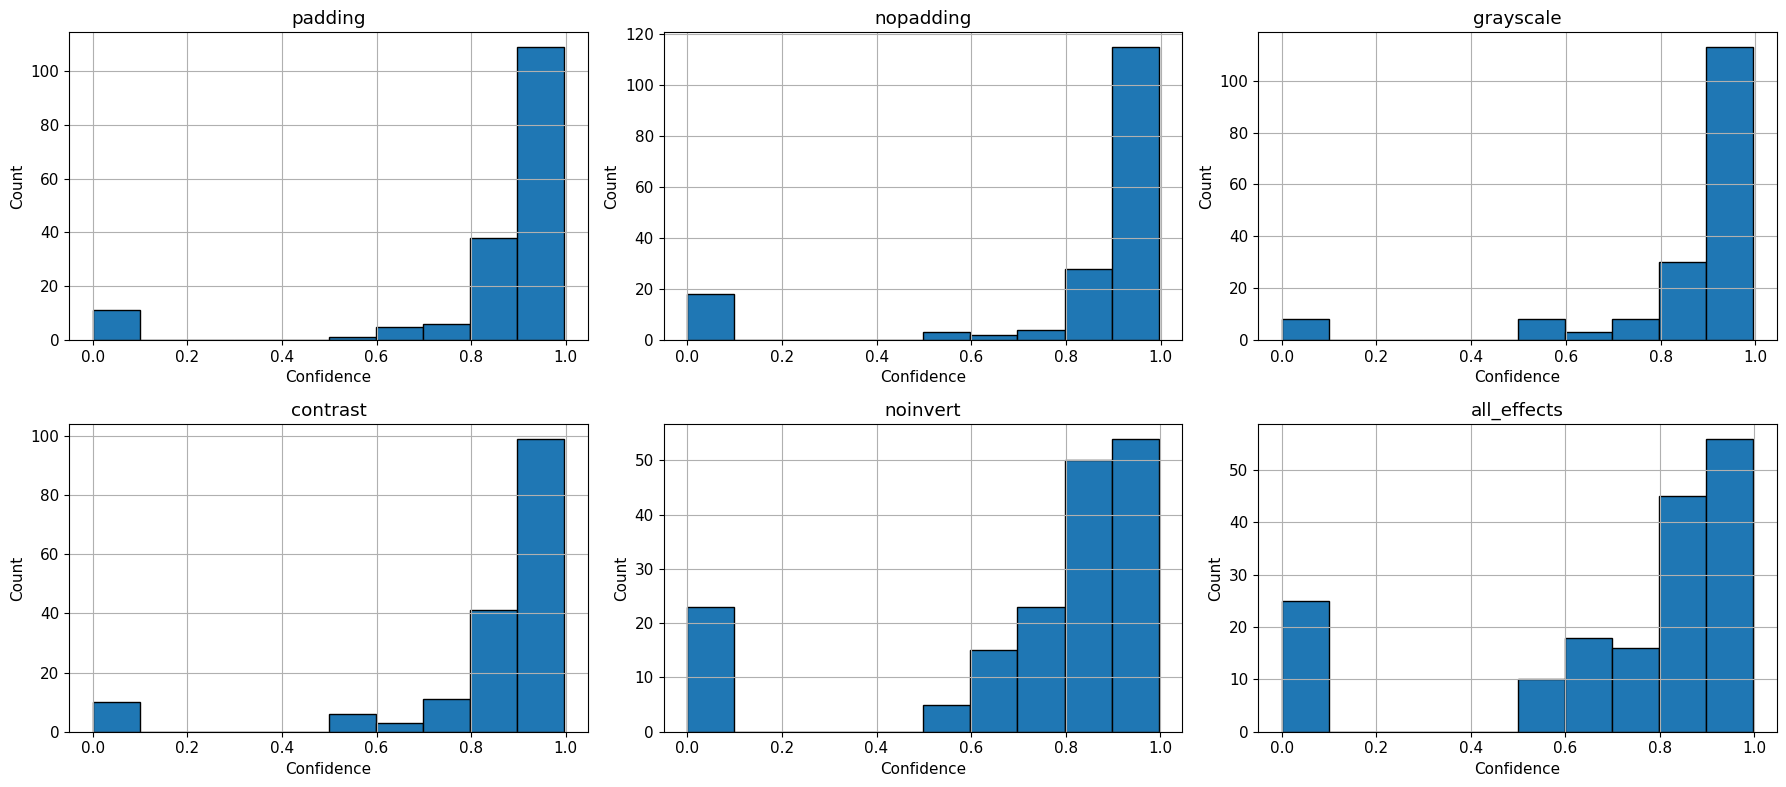

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
%matplotlib inline
for ax, (name, path) in zip(axes.flat, files.items()):
    df = pd.read_excel(path)
    ax.hist(df['confidence'], bins=10, edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel('Confidence')
    ax.set_ylabel('Count')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [35]:
for name, path in files.items():
    df = pd.read_excel(path)
    df['filename'] = df['filename'].str.replace('_obj0', '', regex=False)
    df_merged = pd.merge(df, df_ground_truth, on='filename', how='inner')
    plate_level = _plate_level_accuracy(df_merged)
    edit_dist = average_edit_distance(df_merged)

    df_merged['character_accuracy'] = df_merged.apply(
        lambda row: _character_accuracy(row['ocr_result'], row['corrected_text']), axis=1
    )
    average_character_accuracy = df_merged['character_accuracy'].mean() * 100
    print(f"{name} plate level accuracy: {plate_level:.2f}")
    print(f"{name} average character accuracy: {average_character_accuracy:.2f}")
    print(f"Avg. Edit Distance: {edit_dist:.2f}")
    print("="*50)

padding plate level accuracy: 42.94
padding average character accuracy: 83.28
Avg. Edit Distance: 1.88
nopadding plate level accuracy: 41.18
nopadding average character accuracy: 79.76
Avg. Edit Distance: 2.18
grayscale plate level accuracy: 43.53
grayscale average character accuracy: 82.38
Avg. Edit Distance: 2.02
contrast plate level accuracy: 35.88
contrast average character accuracy: 81.84
Avg. Edit Distance: 2.12
noinvert plate level accuracy: 21.18
noinvert average character accuracy: 65.11
Avg. Edit Distance: 3.85
all_effects plate level accuracy: 17.65
all_effects average character accuracy: 63.33
Avg. Edit Distance: 4.02


In [25]:
for name, path in files.items():
    df = pd.read_excel(path)
    df['filename'] = df['filename'].str.replace('_obj0', '', regex=False)
    df_merged = pd.merge(df, df_ground_truth, on='filename', how='inner')
    cm_df = get_character_confusion(df_merged, output_path=f'confusion_matrix/yolov5/{name}.csv')

Confusion matrix saved to confusion_matrix/yolov5/padding.csv
Confusion matrix saved to confusion_matrix/yolov5/nopadding.csv
Confusion matrix saved to confusion_matrix/yolov5/grayscale.csv
Confusion matrix saved to confusion_matrix/yolov5/contrast.csv
Confusion matrix saved to confusion_matrix/yolov5/noinvert.csv
Confusion matrix saved to confusion_matrix/yolov5/all_effects.csv
